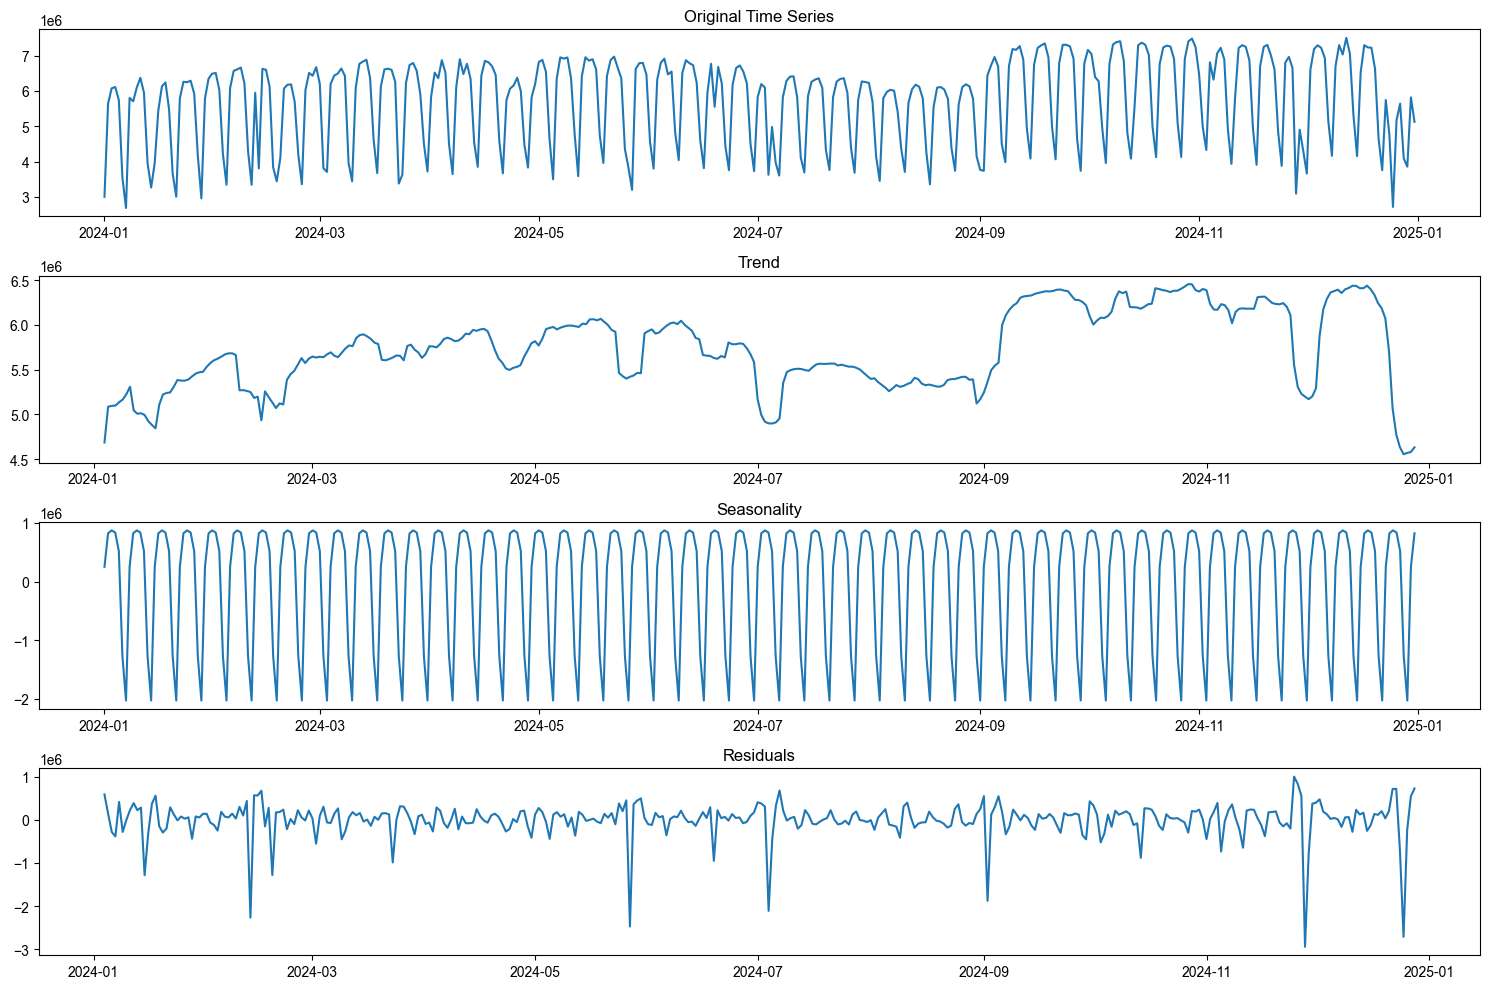

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import pearsonr
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set English display
plt.rcParams['font.sans-serif'] = ['Arial']  
plt.rcParams['axes.unicode_minus'] = True  

# Read data
traffic_df = pd.read_csv('MTA_Ridership_wide_format.csv')
air_df = pd.read_csv('nyc_2024_air.csv')

# Convert Date column to datetime type
traffic_df['Date'] = pd.to_datetime(traffic_df['Date'])
air_df['DATE'] = pd.to_datetime(air_df['DATE'])

# Calculate total daily passenger flow
traffic_df['Total_Traffic'] = traffic_df[['AAR', 'BT', 'Bus', 'LIRR', 'MNR', 'SIR', 'Subway']].sum(axis=1)

# Merge two datasets
merged_df = pd.merge(traffic_df, air_df, left_on='Date', right_on='DATE')

# Create time-related features
merged_df['is_weekend'] = merged_df['Date'].dt.weekday >= 5
merged_df['Month'] = merged_df['Date'].dt.month
merged_df['DayOfWeek'] = merged_df['Date'].dt.dayofweek

# 1. Time Series Decomposition Analysis
plt.figure(figsize=(15, 10))
decomposition = seasonal_decompose(merged_df['Total_Traffic'], period=7)
plt.subplot(411)
plt.plot(merged_df['Date'], decomposition.observed)
plt.title('Original Time Series')
plt.subplot(412)
plt.plot(merged_df['Date'], decomposition.trend)
plt.title('Trend')
plt.subplot(413)
plt.plot(merged_df['Date'], decomposition.seasonal)
plt.title('Seasonality')
plt.subplot(414)
plt.plot(merged_df['Date'], decomposition.resid)
plt.title('Residuals')
plt.tight_layout()
plt.show()


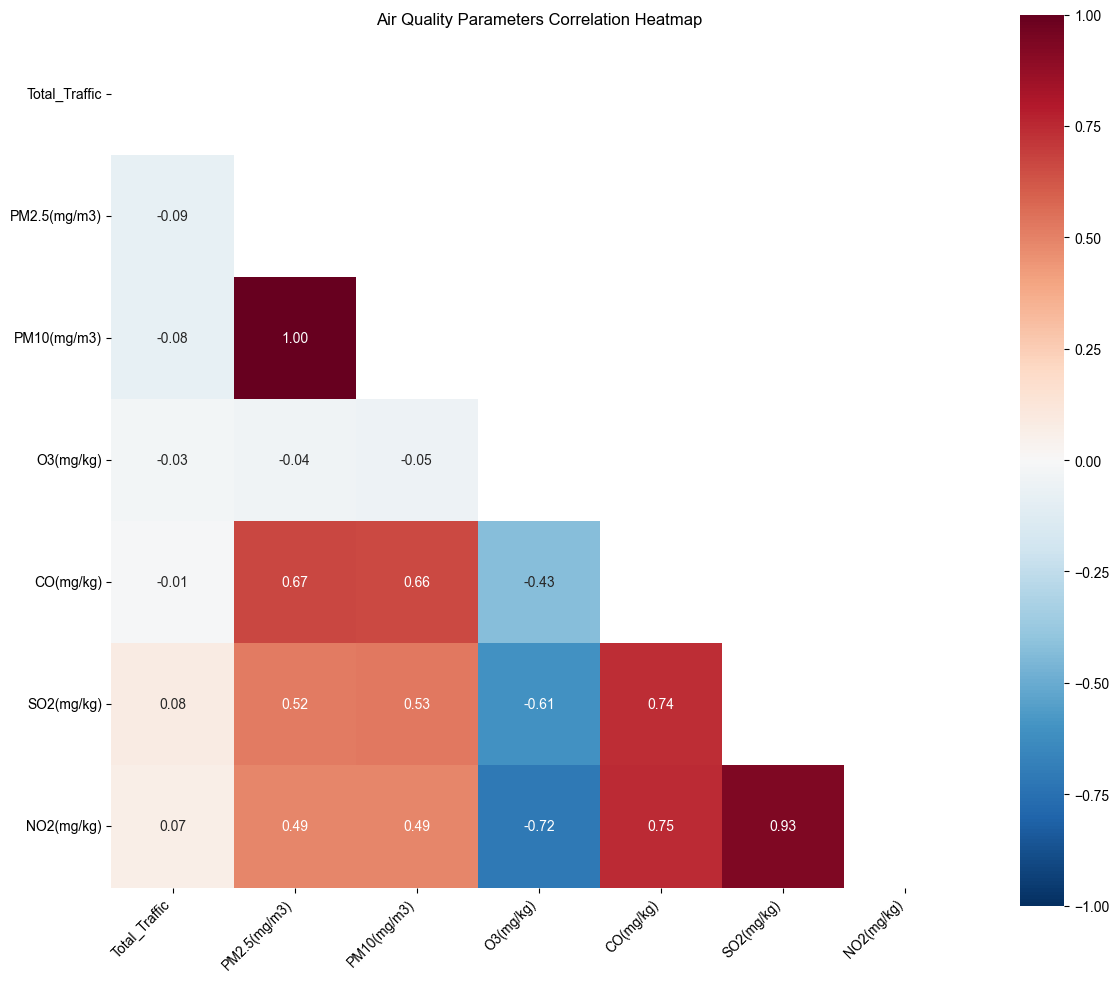

In [3]:

# 3. Improved Correlation Heatmap
plt.figure(figsize=(12, 10))
air_quality_params = ['PM2.5(mg/m3)', 'PM10(mg/m3)', 'O3(mg/kg)', 'CO(mg/kg)', 'SO2(mg/kg)', 'NO2(mg/kg)']
correlation_columns = ['Total_Traffic'] + air_quality_params
correlation_matrix = merged_df[correlation_columns].corr()

mask = np.triu(np.ones_like(correlation_matrix), k=0)
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True,
            cmap='RdBu_r',
            center=0,
            fmt='.2f',
            square=True,
            vmin=-1, vmax=1)
plt.title('Air Quality Parameters Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


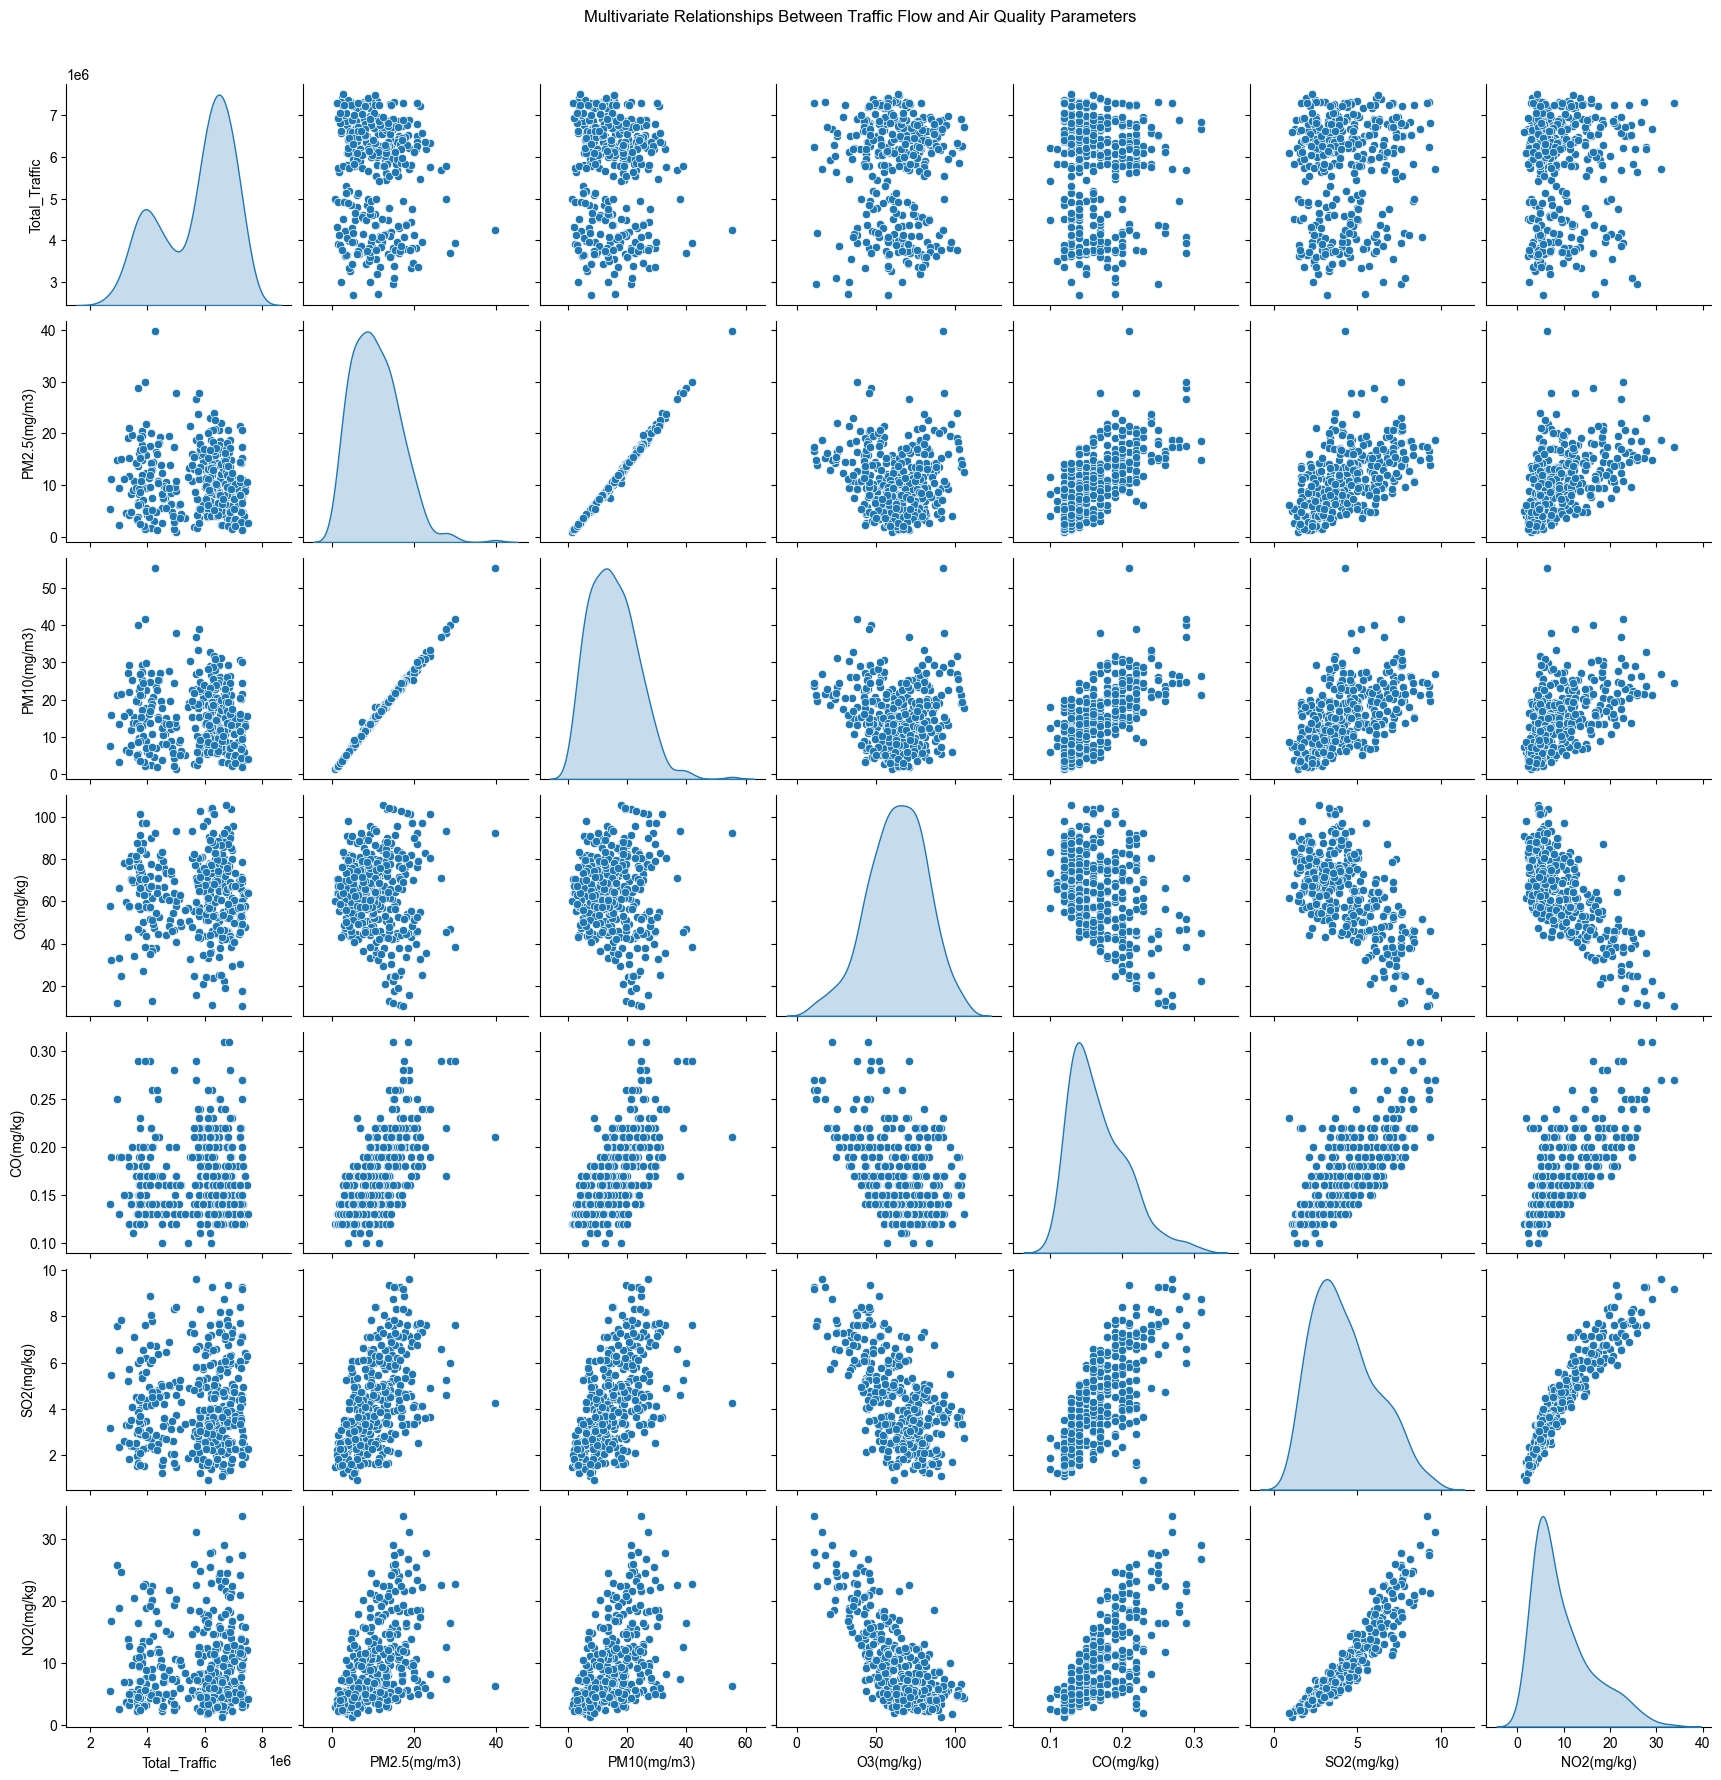

In [4]:

# 4. Multivariate Scatter Plot Matrix
sns.pairplot(merged_df[['Total_Traffic'] + air_quality_params], diag_kind='kde')
plt.suptitle('Multivariate Relationships Between Traffic Flow and Air Quality Parameters', y=1.02)
plt.show()


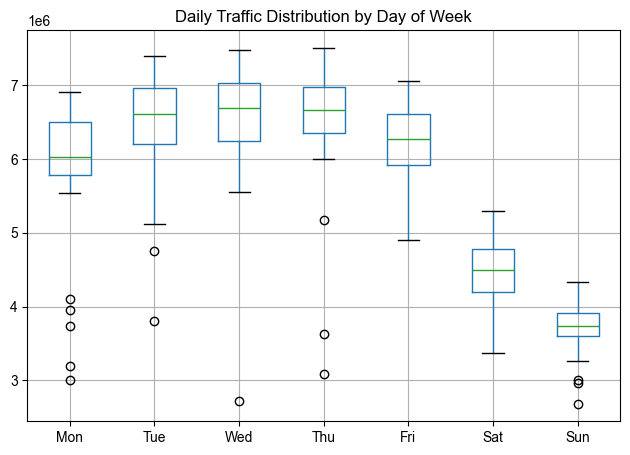

In [31]:

# 5. Time Pattern Distribution Visualization
# Day of Week Traffic Distribution
merged_df.boxplot(column='Total_Traffic', by='DayOfWeek')
plt.title('Daily Traffic Distribution by Day of Week')
plt.suptitle('')
plt.xticks(range(1,8), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('')
plt.tight_layout()
plt.show()


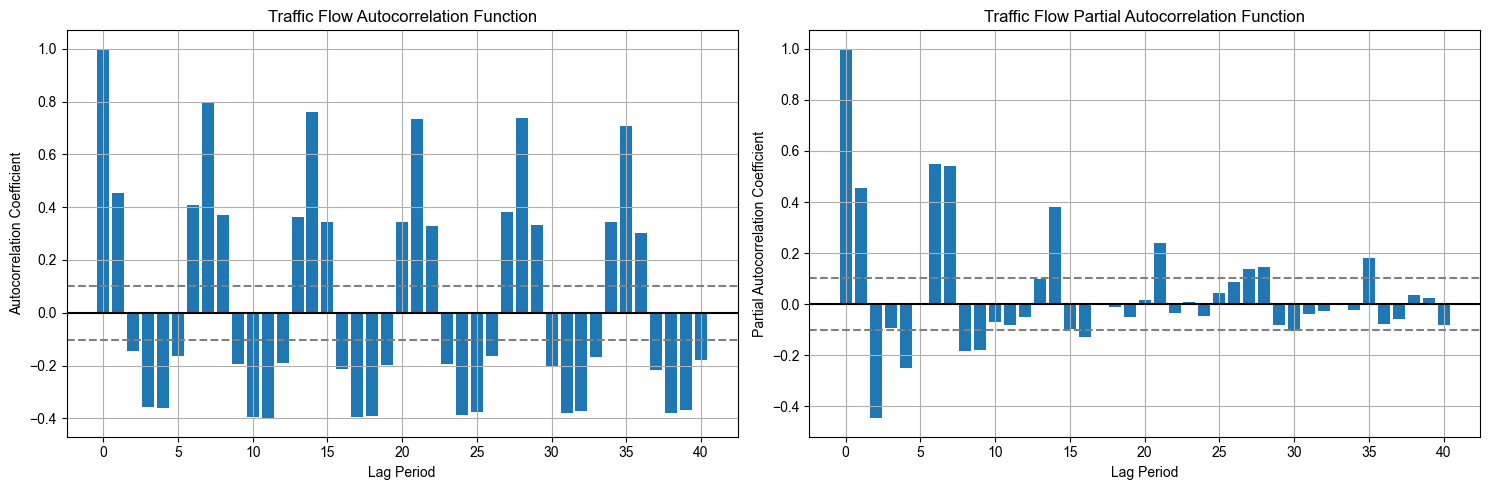

In [8]:

# 8. Autocorrelation Analysis
from statsmodels.tsa.stattools import acf, pacf

# Calculate autocorrelation and partial autocorrelation
nlags = 40
acf_values = acf(merged_df['Total_Traffic'], nlags=nlags)
pacf_values = pacf(merged_df['Total_Traffic'], nlags=nlags)

# Manually plot autocorrelation graphs
plt.figure(figsize=(15, 5))

# Autocorrelation graph
plt.subplot(121)
plt.bar(range(len(acf_values)), acf_values)
plt.axhline(y=0, linestyle='-', color='black')
plt.axhline(y=1.96/np.sqrt(len(merged_df)), linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(merged_df)), linestyle='--', color='gray')
plt.title('Traffic Flow Autocorrelation Function')
plt.xlabel('Lag Period')
plt.ylabel('Autocorrelation Coefficient')
plt.grid(True)

# Partial autocorrelation graph
plt.subplot(122)
plt.bar(range(len(pacf_values)), pacf_values)
plt.axhline(y=0, linestyle='-', color='black')
plt.axhline(y=1.96/np.sqrt(len(merged_df)), linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(merged_df)), linestyle='--', color='gray')
plt.title('Traffic Flow Partial Autocorrelation Function')
plt.xlabel('Lag Period')
plt.ylabel('Partial Autocorrelation Coefficient')
plt.grid(True)

plt.tight_layout()
plt.show()


c:\Users\19812\.conda\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\19812\.conda\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\19812\.conda\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\19812\.conda\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is k

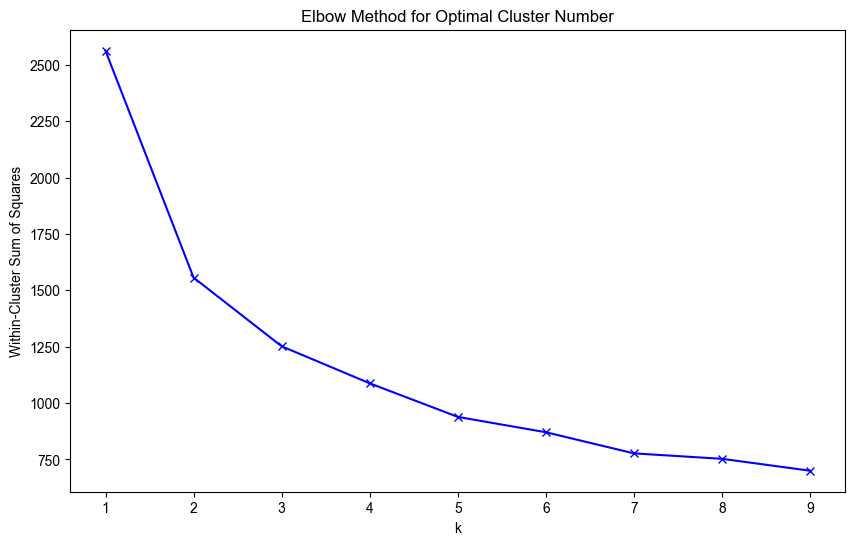

c:\Users\19812\.conda\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


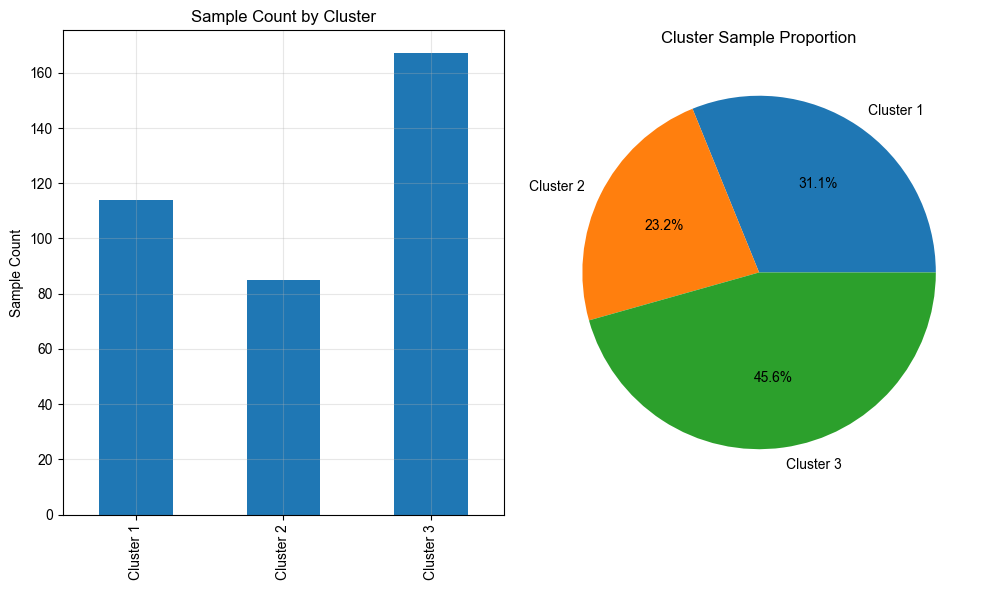

In [9]:

# 9. Cluster Analysis
features = ['Total_Traffic'] + air_quality_params
X = merged_df[features]
X_scaled = StandardScaler().fit_transform(X)

# Determine optimal number of clusters (Elbow Method)
inertias = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('Elbow Method for Optimal Cluster Number')
plt.show()

# Use K=3 for clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Cluster results visualization
cluster_sizes = pd.Series([(clusters == i).sum() for i in range(3)], index=['Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
cluster_sizes.plot(kind='bar')
plt.title('Sample Count by Cluster')
plt.ylabel('Sample Count')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.pie(cluster_sizes, labels=cluster_sizes.index, autopct='%1.1f%%')
plt.title('Cluster Sample Proportion')
plt.tight_layout()
plt.show()


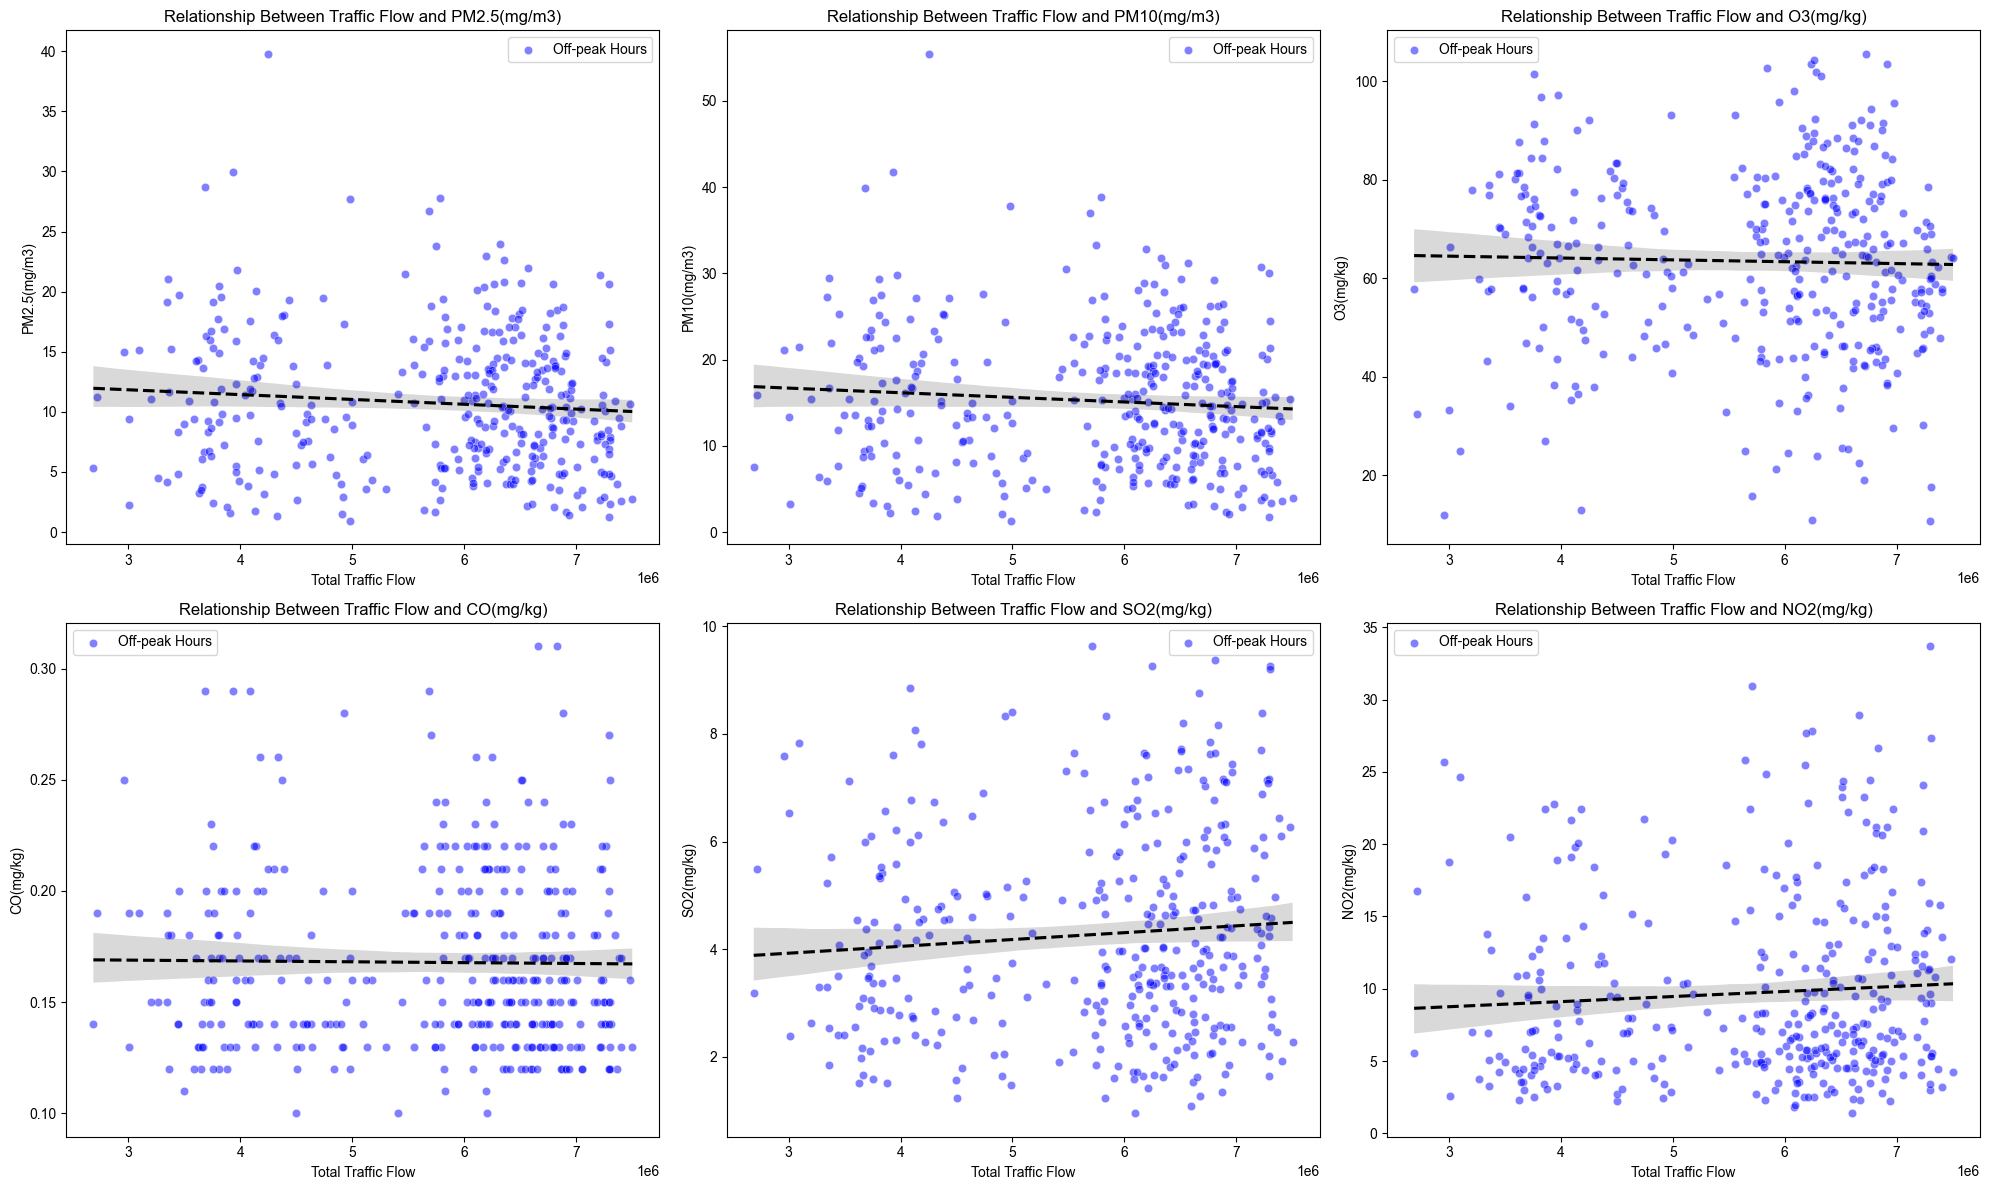

In [12]:

# 12. In-depth Analysis of the Relationship Between Traffic Flow and Air Pollutants
plt.figure(figsize=(20, 12))

# Create lag features
lag_periods = [0, 1, 2, 3]  # Analyze the impact of current day and the next 3 days
air_quality_params = ['PM2.5(mg/m3)', 'PM10(mg/m3)', 'O3(mg/kg)', 'CO(mg/kg)', 'SO2(mg/kg)', 'NO2(mg/kg)']

# Time period analysis
merged_df['Hour'] = merged_df['Date'].dt.hour
peak_hours = merged_df['Hour'].between(7, 9) | merged_df['Hour'].between(17, 19)
off_peak_hours = ~peak_hours

# Create subplot for each air quality parameter
for i, param in enumerate(air_quality_params):
    plt.subplot(2, 3, i+1)
    
    # Draw scatter plots for peak and off-peak hours
    sns.scatterplot(data=merged_df[peak_hours], 
                   x='Total_Traffic', 
                   y=param, 
                   alpha=0.5, 
                   label='Peak Hours',
                   color='red')
    
    sns.scatterplot(data=merged_df[off_peak_hours], 
                   x='Total_Traffic', 
                   y=param, 
                   alpha=0.5, 
                   label='Off-peak Hours',
                   color='blue')
    
    # Add trend line
    sns.regplot(data=merged_df, 
                x='Total_Traffic', 
                y=param, 
                scatter=False, 
                color='black',
                line_kws={'linestyle': '--'})
    
    plt.title(f'Relationship Between Traffic Flow and {param}')
    plt.xlabel('Total Traffic Flow')
    plt.ylabel(param)

plt.tight_layout()
plt.show()


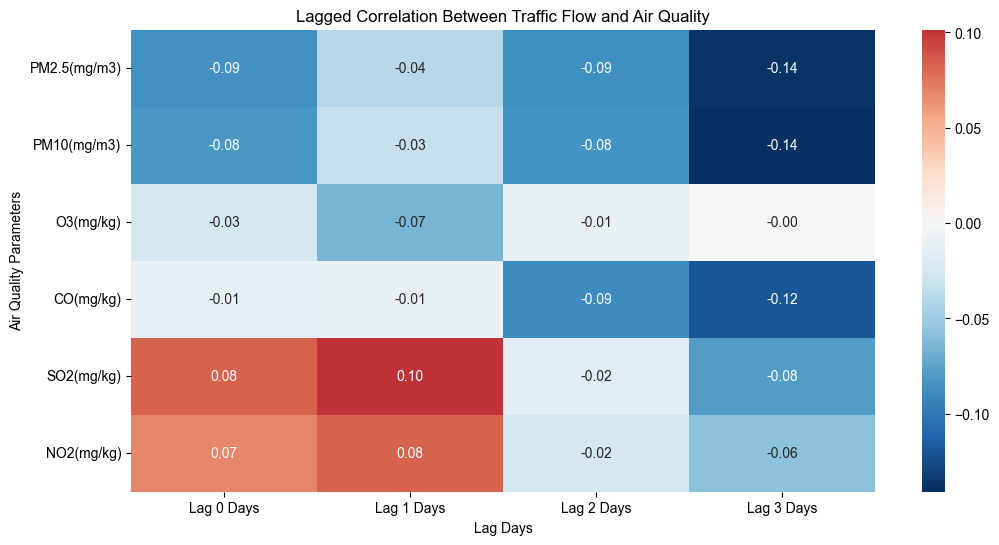

In [13]:

# Modify lag effect analysis section
# 13. Lag Effect Analysis
lag_correlations = np.zeros((len(air_quality_params), len(lag_periods)))

for i, param in enumerate(air_quality_params):
    for j, lag in enumerate(lag_periods):
        # Create lagged series
        traffic_lagged = merged_df['Total_Traffic'].shift(lag)
        # Calculate correlation coefficient
        correlation = traffic_lagged.corr(merged_df[param])
        lag_correlations[i, j] = correlation

# Create DataFrame for better presentation
lag_correlations_df = pd.DataFrame(
    lag_correlations,
    index=air_quality_params,
    columns=[f'Lag {i} Days' for i in lag_periods]
)

# Visualize lag effects
plt.figure(figsize=(12, 6))
sns.heatmap(lag_correlations_df, 
            annot=True, 
            cmap='RdBu_r',
            center=0,
            fmt='.2f')
plt.title('Lagged Correlation Between Traffic Flow and Air Quality')
plt.xlabel('Lag Days')
plt.ylabel('Air Quality Parameters')
plt.show()


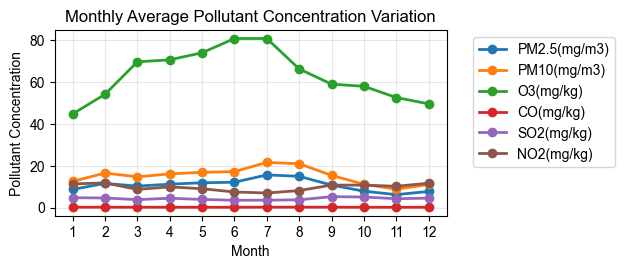


Statistics by Day of Week:
           count          mean            std        min         25%  \
DayOfWeek                                                              
0           53.0  5.931377e+06  867491.842674  3003139.0  5788242.00   
1           53.0  6.517751e+06  699034.041582  3806725.0  6203904.00   
2           52.0  6.603683e+06  713011.031986  2716624.0  6251975.25   
3           52.0  6.560224e+06  792181.467215  3092883.0  6360344.75   
4           52.0  6.249385e+06  506781.823974  4903965.0  5919763.25   
5           52.0  4.458371e+06  421941.674198  3377005.0  4194488.50   
6           52.0  3.715052e+06  319098.697901  2686860.0  3602334.75   

                 50%         75%        max  
DayOfWeek                                    
0          6031295.0  6510108.00  6910995.0  
1          6611020.0  6966036.00  7403890.0  
2          6688871.0  7037341.50  7485061.0  
3          6660874.0  6973275.75  7505450.0  
4          6268480.0  6610778.50  7054050.0  
5

In [17]:

# 2. Monthly pollutant concentration
plt.subplot(2, 1, 2)
for param in air_quality_params:
    monthly_pollution = merged_df.groupby('Month')[param].mean()
    plt.plot(monthly_pollution.index, monthly_pollution.values, 
             marker='o', linewidth=2, label=param)

plt.title('Monthly Average Pollutant Concentration Variation')
plt.xlabel('Month')
plt.ylabel('Pollutant Concentration')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 13))

plt.tight_layout()
plt.show()

# Print statistical information
print("\nStatistics by Day of Week:")
print(merged_df.groupby('DayOfWeek')['Total_Traffic'].describe())

print("\nStatistics by Month:")
print(merged_df.groupby('Month')['Total_Traffic'].describe())

# Calculate comparison of averages between weekdays and weekends
weekday_mask = merged_df['DayOfWeek'] < 5
weekend_mask = merged_df['DayOfWeek'] >= 5

print("\nWeekday vs Weekend Comparison:")
print("Weekday Average Traffic Flow:", merged_df[weekday_mask]['Total_Traffic'].mean())
print("Weekend Average Traffic Flow:", merged_df[weekend_mask]['Total_Traffic'].mean())



=== Detailed Analysis of Different Transportation Modes and Air Quality ===


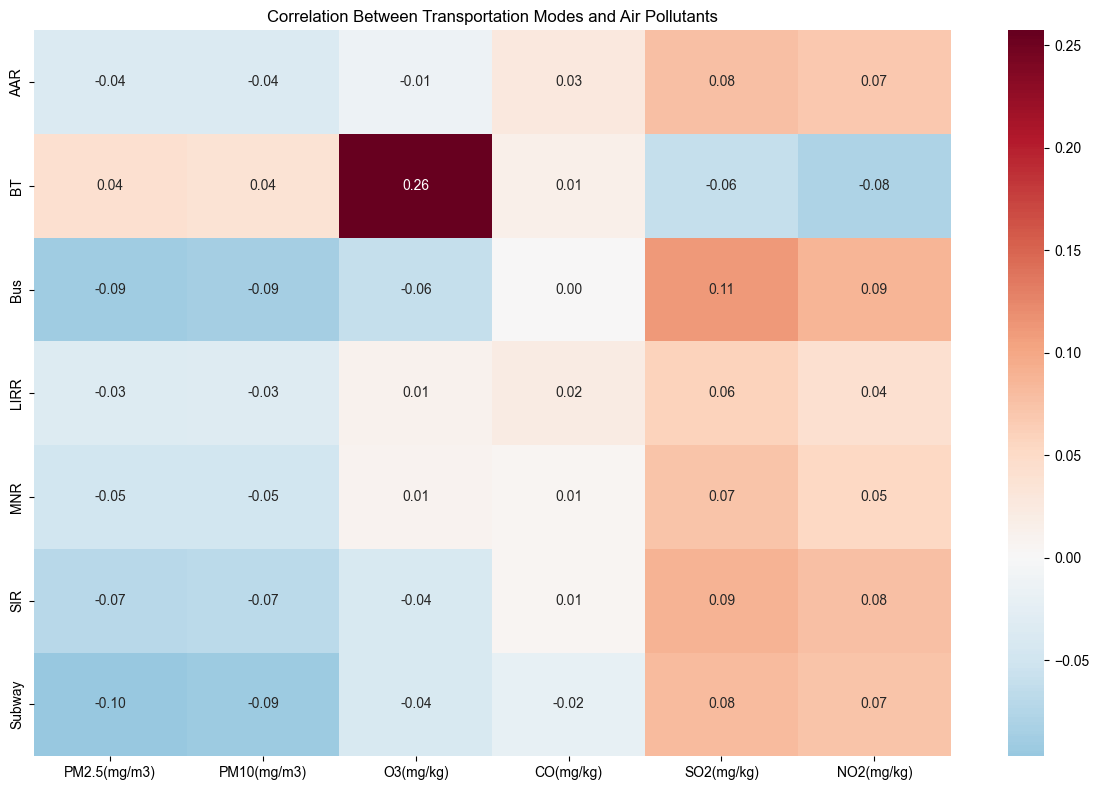

In [19]:
# 15. Separate Analysis of Different Transportation Modes
print("\n=== Detailed Analysis of Different Transportation Modes and Air Quality ===")

transport_modes = ['AAR', 'BT', 'Bus', 'LIRR', 'MNR', 'SIR', 'Subway']
air_quality_params = ['PM2.5(mg/m3)', 'PM10(mg/m3)', 'O3(mg/kg)', 'CO(mg/kg)', 'SO2(mg/kg)', 'NO2(mg/kg)']

# 1. Correlation Analysis
# Create numpy array to store correlation coefficients
corr_matrix = np.zeros((len(transport_modes), len(air_quality_params)))

for i, mode in enumerate(transport_modes):
    for j, param in enumerate(air_quality_params):
        corr = merged_df[mode].astype(float).corr(merged_df[param].astype(float))
        corr_matrix[i, j] = corr

# Convert to DataFrame
correlations = pd.DataFrame(
    corr_matrix,
    index=transport_modes,
    columns=air_quality_params
)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlations, 
            annot=True, 
            cmap='RdBu_r',
            center=0,
            fmt='.2f')
plt.title('Correlation Between Transportation Modes and Air Pollutants')
plt.tight_layout()
plt.show()


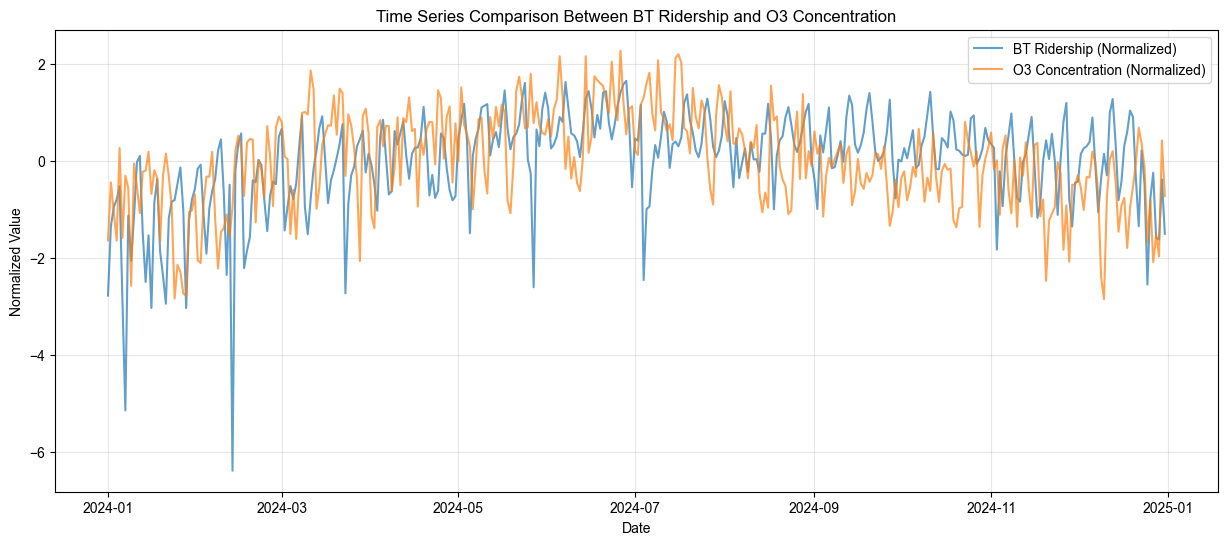

In [32]:

# 4. Print statistical information
# 1. Time series trend comparison
plt.figure(figsize=(15, 6))
# Normalize data for easier comparison
bt_normalized = (merged_df['BT'] - merged_df['BT'].mean()) / merged_df['BT'].std()
o3_normalized = (merged_df['O3(mg/kg)'] - merged_df['O3(mg/kg)'].mean()) / merged_df['O3(mg/kg)'].std()

plt.plot(merged_df['Date'], bt_normalized, label='BT Ridership (Normalized)', alpha=0.7)
plt.plot(merged_df['Date'], o3_normalized, label='O3 Concentration (Normalized)', alpha=0.7)
plt.title('Time Series Comparison Between BT Ridership and O3 Concentration')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


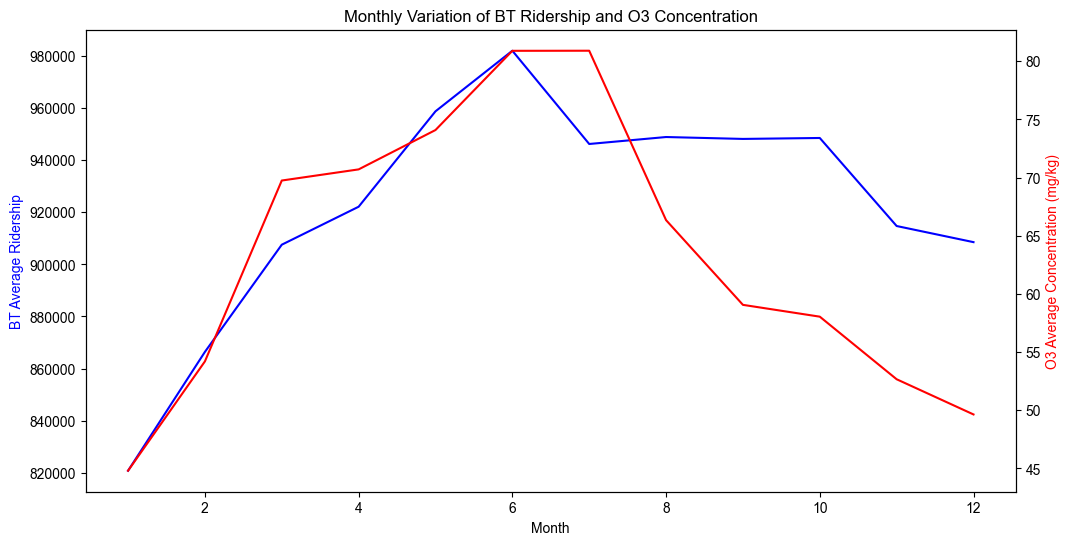

In [23]:

# 2. Analysis by month
plt.figure(figsize=(12, 6))
monthly_data = merged_df.groupby(merged_df['Date'].dt.month).agg({
    'BT': 'mean',
    'O3(mg/kg)': 'mean'
}).reset_index()

ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(monthly_data['Date'], monthly_data['BT'], 'b-', label='BT Ridership')
ax2.plot(monthly_data['Date'], monthly_data['O3(mg/kg)'], 'r-', label='O3 Concentration')

ax1.set_xlabel('Month')
ax1.set_ylabel('BT Average Ridership', color='b')
ax2.set_ylabel('O3 Average Concentration (mg/kg)', color='r')

plt.title('Monthly Variation of BT Ridership and O3 Concentration')
plt.show()


In [25]:

# 4. Correlation statistical analysis
# Calculate Pearson correlation coefficient and p-value
from scipy import stats
correlation, p_value = stats.pearsonr(merged_df['BT'], merged_df['O3(mg/kg)'])

print("\nCorrelation Analysis Between BT and O3:")
print(f"Pearson Correlation Coefficient: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")



Correlation Analysis Between BT and O3:
Pearson Correlation Coefficient: 0.257
P-value: 0.000


In [26]:

# 5. Conditional analysis
# Group by O3 concentration level
o3_median = merged_df['O3(mg/kg)'].median()
high_o3 = merged_df[merged_df['O3(mg/kg)'] > o3_median]
low_o3 = merged_df[merged_df['O3(mg/kg)'] <= o3_median]

print("\nBT Ridership Statistics at Different O3 Concentration Levels:")
print("\nBT Ridership During High O3 Concentration Periods:")
print(high_o3['BT'].describe())
print("\nBT Ridership During Low O3 Concentration Periods:")
print(low_o3['BT'].describe())



BT Ridership Statistics at Different O3 Concentration Levels:

BT Ridership During High O3 Concentration Periods:
count    1.830000e+02
mean     9.374312e+05
std      5.722763e+04
min      7.187770e+05
25%      9.095585e+05
50%      9.466960e+05
75%      9.773115e+05
max      1.037403e+06
Name: BT, dtype: float64

BT Ridership During Low O3 Concentration Periods:
count    1.830000e+02
mean     9.081818e+05
std      7.711210e+04
min      4.801780e+05
25%      8.696585e+05
50%      9.246230e+05
75%      9.552315e+05
max      1.035803e+06
Name: BT, dtype: float64


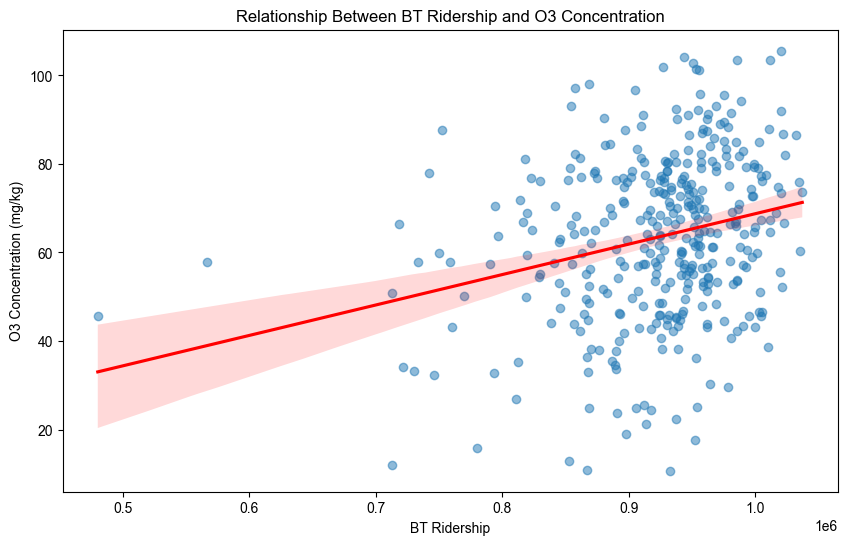

In [27]:

# 6. Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='BT', y='O3(mg/kg)', data=merged_df, 
            scatter_kws={'alpha':0.5}, 
            line_kws={'color': 'red'})
plt.title('Relationship Between BT Ridership and O3 Concentration')
plt.xlabel('BT Ridership')
plt.ylabel('O3 Concentration (mg/kg)')
plt.show()


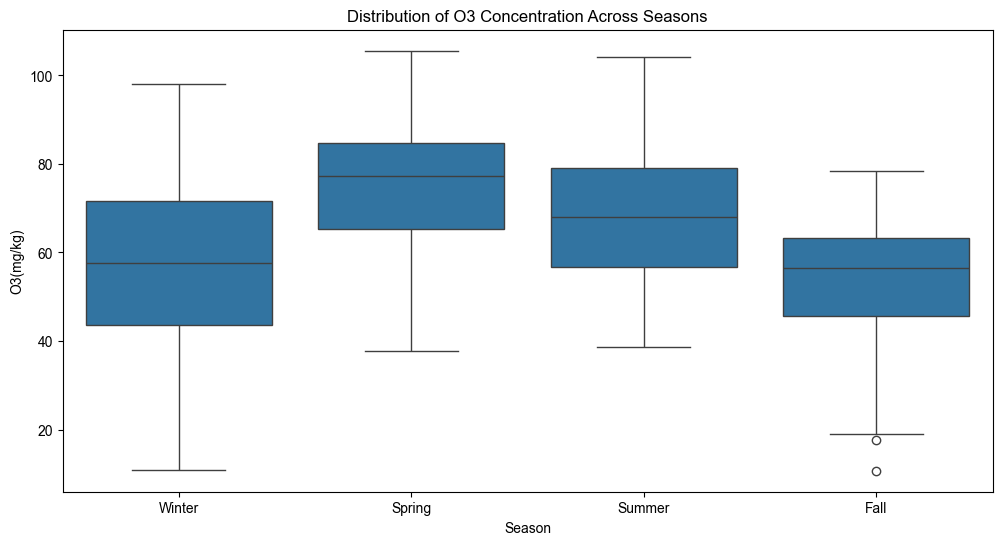

In [28]:

# 7. Seasonal analysis
merged_df['Season'] = pd.cut(merged_df['Date'].dt.month, 
                           bins=[0,3,6,9,12], 
                           labels=['Winter','Spring','Summer','Fall'])

plt.figure(figsize=(12, 6))
sns.boxplot(x='Season', y='O3(mg/kg)', data=merged_df)
plt.title('Distribution of O3 Concentration Across Seasons')
plt.show()
